# Bayesian and Empirical Bayesian Forests

<br><br>
__Abstract:__  We interpret random forests via the framework of distribution-free nonparametric Bayesian analysis, so that the ensemble average is an approximation to posterior mean inference for the population CART tree. This insight motivates a class of fully Bayesian Forest (BF) algorithms that provide small gains in predictive performance and large gains in interpretability (from a Bayesian perspective) over their classically bagged predecessors. The framework is then applied to derive Empirical Bayesian Forests (EBF), in which a single short tree "trunk" is estimated and Bayesian Forests are fit to the data at each leaf of the trunk. We are able to derive conditions under which this fixed trunk has high posterior probability, and demonstrate that in such settings the EBF performs nearly as well in out-of-sample prediction as the full BF. The advantage of pre-partitioning a fixed trunk is that the EBF ensembles can be fit independently for each initial partition. This implies a novel strategy for fitting tree ensemble predictors on data stored in a distributed file system (such as HDFS), and we show that it strongly outperforms the common strategy of fitting forests to without-replacement data subsets. The work is illustrated on a number of publicly available examples, and on massive data from eBay.com. 
<br><br>

## Introduction

Decision trees are a fundamental tool for machine learning.  Such trees partition the attribute (input) space into regions of response homogenaity, such that the response (output) value associated with any point in a given region can be predicted from the average of other observations in that region.  The classification and regression tree (CART) algorithm of Breiman et al (1984) is a common and useful recipe for building trees; it greedily grows a tree through a series of partitions on input features, each of which maximizes reduction in some measure of inpurity at the current tree leaves (terminal nodes; i.e., the implied imput space partitioning).  The development of _random forests_ (RF) by Brieman in 2001, which predict through the average of many CART trees fit to bootstrap re-samples of the data, provided an  archetype for the hugely successful strategy of _tree ensemble learning._  For prediction problems with relatively small input dimensions (or in conjunction with dimension reduction strategies) properly trained ensembles of trees -- or forests -- can predict out-of-the-box as well as any carefully tuned, application-specific alternative.

This review details a straightforward, but not well-recognized, nonparametric Bayesian interpretation of random forests.  Imagine the CART fit for a _population_ data generating process (DGP) with finite support.  This CART greedily partitions the feature support to minimize impurity of the response distribtion conditional on each partition region, and we suppose it terminates while each leaf node has probability greater than some threshold. If we agree that such a population-CART is an useful statistic (i.e., would be useful for prediction) then its posterior mean is of interest as the optimal Bayesian estimator of a useful statistic.   The posterior distribution of CART fits is induced by our nonparametric Bayesian posterior over random DGPs.
The random forest set of trees is an approximate sample from this posterior, such that the RF predictor is a _posterior mean_ prediction rule.  A simple alteration of the RF algorithm leads to an exact sample from the posterior, which we label as a _Bayesian forest_.  The altered BF algorithm offers a small but reliable improvement on RFs.  However, the big gain is interpretability: when should R/B forests work, and when should we expect the more restrictive Bayesian tree models to be preferable?  

The interpretable model also allows us to assess appropriateness of various Big Data distributed computing schemes for their ability to recover the posterior mean. From this, we propose Empirical Bayesian Forests (EBF) in which a single short tree "trunk" is estimated and Bayesian Forests are fit to the data at each leaf of the trunk. We are able to derive conditions under which this fixed trunk has high posterior probability, and demonstrate that in such settings the EBF performs nearly as well in out-of-sample prediction as the full BF. The advantage of pre-partitioning a fixed trunk is that the EBF ensembles can be fit independently for each initial partition. This implies a novel strategy for fitting tree ensemble predictors on data stored in a distributed file system (such as HDFS), and we show that it strongly outperforms the common strategy of fitting forests to without-replacement data subsets. The work is illustrated on a number of publicly available examples, and on massive data from eBay.com. 



## Nonparametric Bayesian Forests

The classical _distribution free_ framework of nonparametric inference <cite data-cite="hollander_nonparametric_1999">(see, e.g., Hollander + Wolfe, 1999)</cite> has two components:
1. find a _nonparametric statistic_ $\mathcal{T}(\text{DGP})$ that is of interest in your application regardless of the true data generating process (DGP),
2. and derive a sampling distribution on $\mathcal{T}$ under minimal assumptions on the DGP.

The Bayesian version of this procedure replaces step 2 with 

&nbsp;&nbsp;2b.  build a flexible model for the DGP, and derive the posterior distribution on $\mathcal{T}(\text{DGP})$ from the posterior distribution on possible DGPs.

As detailed below, a simple and powerful nonparametric Bayesian framework models the data generating process through a multinomial probability
function on a large number of possible $\mathbf{z} = \{\mathbf{x},y\}$ input-output points. We apply a limiting
non-informative prior, which implies using the observed data as our
approximation for the population support.  This provides a posterior over
possible DGPs.

In the context of this article, 1. is clearly referring to decision trees.   Indeed, trees are useful precisely because they are good predictors regardless of the underlying data distribution -- they do not rely upon distributional assumptions to share information across training observations.  In particular, we'll define $\mathcal{T}$ as the greedy CART fit for a decision tree that terminates at some minimum leaf probability threshold.  For any realization of the DGP -- which will be a probability function over finite support -- the CART tree $\mathcal{T}(\text{DGP})$
greedily splits to minimize impurity of the response distribtion conditional on each partition region.
If we can sample from the posterior over DGPs (i.e., sample weights on the support), then a forest is constructed by fitting CART to each posterior DGP draw.  The forest is a posterior sample of tree statistics, and  the ensemble average prediction is interpretable as a posterior mean.


The forest predictor is a posterior mean for the population CART tree.  This makes it clear when we should expect such forests to do a good job in prediction: when this tree provides a good summary of the conditional response distribution.  This will be the case when the greedy algorithm leads to a good partitioning -- for example, when you have lots of data and a relatively low dimensional feature space.  It will not do as well when the greedy algorithm is unreliable; e.g., in high dimensions, especially when many feature dimensions have little or no influence on the response (i.e., in situations were, even if nonparametric partitioning is the correct approach, the greedy algorithm is likely to converge to a minor mode much worse than best).  More importantly, a forest predictor will also be the inappropriate choice whenever compared against models with properties reflected in the true data generating process.  For example, if the response is a linear function of the features, then knowing the equation for this line through the population is _much more useful_ than any partitioning summary.  Or if the idiosynchratic error around the unknown conditional mean function is homoskedastic, we will get better predictions if we use that information when summarizing the conditional response distribution.  The use of Random or Bayesian forests should thus be reserved for situations where we _need_ to be distribution free -- when the conditional response function defies parametric representation. 



### Model for the data generating process

We  employ a Dirichlet-multinomial sampling model in nonparametric Bayesian (NPB) analysis.  The approach dates back to <cite data-cite="ferguson_bayesian_1973">Ferguson (1973)</cite>. 
<cite data-cite="chamberlain_nonparametric_2003">Chamberlain + Imbens (2003)</cite> provide an overview in the context of
econometric problems.
<cite data-cite="rubin_bayesian_1981">Rubin (1981)</cite> proposed the Bayesian bootstrap as an algorithm for
sampling from versions of the posterior implied by this strategy, and the
algorithm has since become closely associated with this model.

Use $\mathbf{z}_i = \{\mathbf{x}_i,y_i\}$ to denote the complete feature and response observation for unit $i$. We suppose that data are drawn _independently_ from a finite number $L$ of possible values,

\begin{equation}
\mathrm{p}(\mathbf{z}) = \sum_{l=1}^L \omega_l \mathbb{1}{[\mathbf{z} = \boldsymbol{\zeta}_l]}
\end{equation}

where $\omega_l\geq0\forall l$ and $\sum_l \omega_l = 1$.  Thus the generating process for observation $i$ samples $l_i$ from a multinomial with probability $\omega_{l_i}$, and this indexes one of the $L$ support points.  Since $L$ can be arbitrarily large, and all data are stored as discrete (up to machine tolerance), this so-far implies no restrictive assumptions beyond that of independence.

The conjugate prior for $\boldsymbol{\omega}$ is a Dirichlet distribution, written
$\mathrm{Dir}(\boldsymbol{\omega}; \boldsymbol{\nu}) \propto \prod_{l=1}^L\omega_j^{\nu_l-1}$.  We
will parametrize the prior with a single concentration parameter $\boldsymbol{\nu} =
a >0$, such that $\mathbb{E}[\omega_l] = a/La = 1/L$ and $\mathrm{var}(\omega_l) =
(L-1)/[L^2(La+1)]$. Suppose you have the observed sample $\mathbf{Z} = [\mathbf{z}_1
\cdots \mathbf{z}_n]'$.  For convenience, we allow $\boldsymbol{\zeta}_l=\boldsymbol{\zeta}_k$ for $l \neq k$
in the case of repeated values. Write $l_1 \dots l_n = 1 \dots n$ so
that $\mathbf{z}_i = \boldsymbol{\zeta}_i$ and $\mathbf{Z} = [\boldsymbol{\zeta}_1 \cdots \boldsymbol{\zeta}_n]'$.  Then the posterior
distribution for $\boldsymbol{\omega}$ has $\omega_i = a+1$ for $i\leq n$ and $\omega_l = a$ for $l>n$, so that

\begin{equation}
\mathrm{p}(\boldsymbol{\omega} ) \propto \prod_{i=1}^n \omega_i^{a} \prod_{l=n+1}^L \omega_l^{a-1}.
\end{equation}

This, in turn, defines our posterior for the data generating process through our sampling model above.

There are many possible strategies for specification of $a$ and $\zeta_l$ for
$l>n$. (The unobserved $\zeta_l$ act as data we imagine we might have
seen, to smooth the posterior away from the data we have actually observed.
See <cite data-cite="poirier_bayesian_2011">Poirier (2011)</cite> for discussion of how such values can be
useful in application.)  The non-informative prior that arises as
$a\rightarrow 0$ is a default with massive computational
convenience: in this limit, $\omega_l = 0$ with probability one for
$l>n$. (To see this, note that for $l>n$ the posterior has
$\mathbb{E}[\omega_l]=0$ with variance $\mathrm{var}(\omega_l) = \lim_{a \to 0}
a[n+a(L-1)]/[(n+La)^2(n+La+1)] = 0$.)  We apply this limiting prior
throughout, such that our posterior for the data generating process is
a multinomial draw from the _observed data points_, with a uniform
$\mathrm{Dir}(\boldsymbol{1})$ distribution on the $\boldsymbol{\omega} = [\omega_1 \dots
\omega_n]'$ sampling probabilities.


### Posterior inference and Bayesian forests

Conditional upon $\boldsymbol{\omega}$, the population tree $\mathcal{T}(\text{DGP})$ is defined through a weighted-sample of the CART version.  In particular, given data $\mathbf{Z}^\eta = \{\mathbf{X}^\eta,\mathbf{y}^\eta\}$ in node $\eta$, sort through all dimensions of all observations in $\mathbf{Z}^\eta$ to find the split that minimizes the average of some $\boldsymbol{\omega}$ impurity metric across the two new child nodes.  For example, in the case of regression trees (which we focus on), the impurity to minimize is weighted-squared error

\begin{equation}
\mathcal{I}(\mathbf{y}^\eta) = \sum_{i\in \eta} \omega_i (y_i - \bar y^\eta )^2
\end{equation}

with $\bar y^\eta =\omega_i y_i/\|\boldsymbol{\omega}^\eta\|_0$.  This is repeated on every leaf of the tree, and the algorithm terminates when no split leads to a new child $\|\boldsymbol{\omega}^{\eta^c}\|_0$ with $\|\boldsymbol{\omega}^{\eta^{c}}\|_0$ greater than some threshold.  We'll refer to the resulting weighted CART as $\mathcal{T}(\boldsymbol{\omega})$.

Following <cite data-cite="rubin_bayesian_1981">Rubin (1981)</cite> we can obtain a sample from the posterior
on $\mathcal{T}(\boldsymbol{\omega})$ through a simple Bayesian bootstrap: for $b=1,\dots, B$,

 * draw $\boldsymbol{\omega}^b \sim \mathrm{Exp}(\mathbf{1})$, and set $\boldsymbol{\Omega}^b = \mathrm{diag}(\boldsymbol{\omega}^b)$; then
 * run CART to get $\mathcal{T}(\boldsymbol{\omega})$

We call this a Bayesian Forest, and it differs from a traditional random forest only in that the weights are drawn from a Dirichlet distribution rather than a multinomial distribution.  To the extent that RF sampling provides a coarse approximation to the BF samples, the former is a convenient (and computationally advantageous, since fewer observations need to be optimized over) approximation. 

### Implementation via scikit-learn

We can implement a BF through simple adjustement of the `ensemble` module of `scikit-learn` (`sklearn`).  Upon altering the forest `sample_counts` when bootsrapping to be exponential rather than binomial, we get a bayesian bootstrap. We flag this alternative Bayesian bootstrap by passing `boostrap=2` in any forest class construction (this is documented as a boolean, so we're taking advantage of easy conversion to int).


In detail, lines 88-89 of [forest.py](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/forest.py) change from 

``
indices = random_state.randint(0, n_samples, n_samples)
sample_counts = np.bincount(indices, minlength=n_samples)
``

to

            ### bayesian forest      
            if forest.bootstrap == 2:
                sample_counts = random_state.exponential(1,n_samples)
            else:    
                indices = random_state.randint(0, n_samples, n_samples)
                sample_counts = np.bincount(indices, minlength=n_samples)
            
            #print("bs of %d and first 5 weights:" % forest.bootstrap)
            #print(sample_counts[0:5])
            ###################

You can install the updates with
`python setup.py install --user`, and
see the script below for how to append this local scipy in front of, say, the anaconda standard.  To check that your change is taking effect, add a print statment like      

``
print("bs of %d and first 5 weights:" % forest.bootstrap)
print(sample_counts[0:5])
``




### Motorcycle data illustration

We illustrate the various models with a simple one-dimensional prediction problem: what is the velocity of a motorcyle helmet after impact in a crash?  This data, taken from the MASS library for R, provides a series of measurements of crash-test-dummy head acceleration in simulated motorcycle accidents.

In [1]:
import sys
# give preference to local update
sys.path.append("~/.local/lib/python3.4/site-packages")

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
import numpy.random as rn

%matplotlib inline
plt.rc('figure', figsize=(14,6))
plt.rc('figure.subplot', wspace=.33)

In [2]:
mcycle = pd.read_csv('data/mcycle.csv')
Xm = mcycle['times'].values.reshape(-1,1)
ym = mcycle['accel'].values

In [3]:
def mcycle_plot(mod,title,**kwargs):
    plt.scatter(mcycle['times'],mcycle['accel'],**kwargs)
    plt.xlabel("seconds", fontsize=16)
    plt.ylabel("acceleration", fontsize=16)
    plt.title(title, fontsize=18, y=1.05)

    xgrid = np.arange(0,60,1).reshape(-1,1)
    plt.plot(xgrid, mod.predict(xgrid),color="red",linewidth=2)


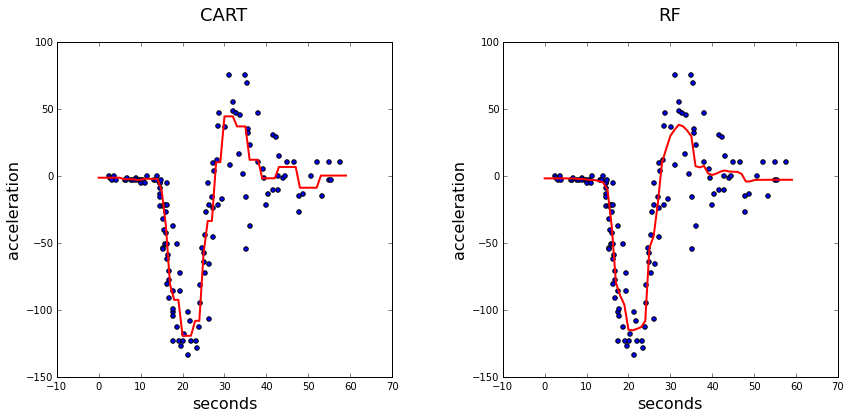

In [4]:
# a simple cart fit
mcycle_dt = tree.DecisionTreeRegressor(min_samples_leaf=5)
mcycle_dt.fit(Xm,ym)
# random forest 
mcycle_rf = ensemble.RandomForestRegressor(100,min_samples_leaf=5)
mcycle_rf.fit(Xm,ym)

# plot them
plt.figure(1)
plt.subplot(121)
mcycle_plot(mcycle_dt, "CART")

plt.subplot(122)
mcycle_plot(mcycle_rf, "RF")


bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes


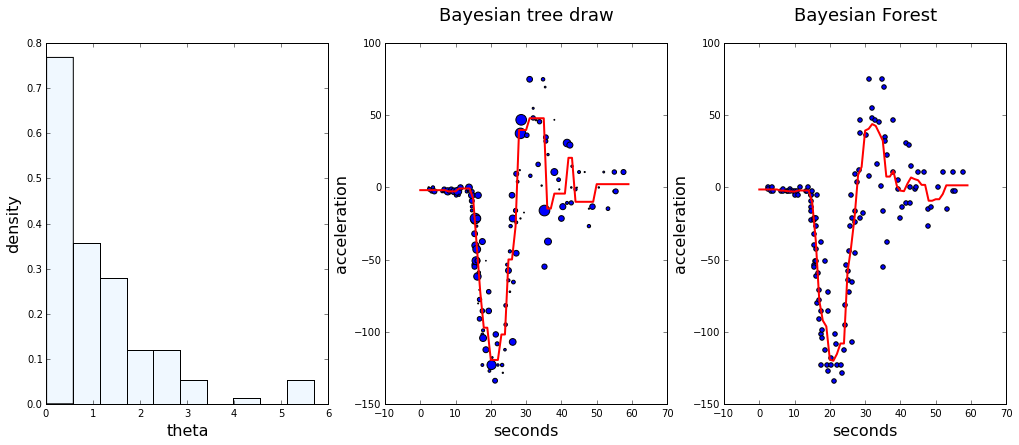

In [5]:
# single bayesian cart draw
omega = rn.exponential(1,mcycle.shape[0])
mcycle_bt = tree.DecisionTreeRegressor(min_samples_leaf=5)
mcycle_bt.fit(Xm, ym, sample_weight=omega)
# bayesian forest
mcycle_bf = ensemble.RandomForestRegressor(100,min_samples_leaf=5, bootstrap=2)
mcycle_bf.fit(Xm,ym)

plt.subplot(131)
plt.hist(omega,normed=1,color="aliceblue")
plt.xlabel("theta", fontsize=16)
plt.ylabel("density", fontsize=16)

plt.subplot(132)
mcycle_plot(mcycle_bt, "Bayesian tree draw", s=omega*20)

plt.subplot(133)
mcycle_plot(mcycle_bf, "Bayesian Forest")

plt.tight_layout(pad=.1,w_pad=0)


## Bayesian tree-as-parameter models

Our multinomial-sampling npB analysis, inspired by classical distribution-free strategies, can be viewed as a minimal-assumption baseline Bayesian treatment.  There are plenty of other Bayesian analyses of decision trees in the literature. All of these methods treat the tree as a _parameter_ which governs the DGP, rather than a functional thereof, and thus place some set of restrictions on the functional form of the distributional  relationship between inputs and outputs.   This section will survey these models and estimators, emphasizing that our Bayesian Forest framework allows us to place some intuition underneath the question of when each of these methods will be more appropriate that the completely nonparametric BF (or RF) baseline.    

The original Bayesian tree model is the _Bayesian CART_ (BCART) of <cite cite-info="chipman_bayesian_1198">Chipman, George, and McCulloch (1998)</cite>. BCART treats the set of all possible decision tree fits as the support for their target parameter, and they devise a prior on trees in this set that has tree probability decreasing with its complexity (maximum depth and number of node, such that trees that are equivalent on these properties are equally likely in the prior).  The data model is specified for response $y$ _conditional upon_ $\mathbf{x}$, and holds that conditional upon a given tree the responses for all observations who are allocated (via $\mathbf{x}$) to the same leaf node are IID from some parametric family.  For regression trees, observations in each leaf node are IID Normal with shared variance and mean.  For classification trees, each leaf represents single probability function over outcome classes.

BCART is fit through Markov chain Monte Carlo (MCMC).  The algorithm draws a (correlated) posterior sample by proposing a number of possible changes to existing tree fit (e.g. grow or prune a given leaf node in the current tree) and accepting those changes (and thus move to new posterior tree draw) with probabilities proportional to the tree prior times leaf likelihood.  A natural extension of this framework is to consider alternative leaf models.  The original BART authors proposed linear regression at leaves, while the Treed Gaussian Processes of <cite data-cite="gramacy_bayesian_2008">Gramacy+Lee (TGP; 2008)</cite> use Gaussian procees regression at each leaf node.  The TGP models, in particular, are very appealing in that they use the tree structure (one flexible regression model) to allow for nonstationarity in the Gaussian processes (another flexible regression model).  As an alternative to MCMC-based tree frameworks, <cite data-cite="taddy_dynamic_2011">Taddy, Gramacy, + Polson (2011)</cite> proposed dynamic regression trees (dynaTree) fit through sequential Monte Carlo (SMC).  In particular, dynaTree uses a particle-filtering to sequentially update a particle set of potential trees for the arrival of new data with basic (grow, prune) tree operations -- they allow the tree to grow naturally with streaming data.

MCMC and SMC seem naturally suited to analysis of CART, as their sampling of tree space relies upon the same incremental moves that are familiar from the construction of classical CART fits.  However, this also means that these sampling algorithms are subject to the same _problems_ CART has: they tend to get stuck in small regions of tree-space.  For dynaTree SMC, the quality of the particle set degrades quickly (although for truly streaming data, particle rejuvination can help dramatically and has the secondary benefit of allowing tree structure to change in time).    The issue is alleviated by having more complex leaf models, as in TGP, since then shorter (easier to sample efficiently) trees are required for fitting the data.  Standard Monte Carlo algorithm enhancements, such as multiple parallel chains, can also help.  But a full exploration of BCART-style tree space remains very difficult and requires extremely large Markov samples to have any chance of convergence.  

As a solution to these mixing issues, the original BCART authors proposed Bayesian Additive Regression Trees <cite data-cite="chipman_bart:_2010">(BART; 2010)</cite>, which replaces the single tree model with the sum of many small trees.  Thus, a single observation is allocated via its features to a leaf node in each of, say, $T$ trees; the associated response is then distributed with mean equal to the average of each leaf node value and with a _shared variance across observations_.  The original BART model assumes Normal response, and later extensions allow alternative response families (including nonparametric mixtures of Normals).    BART solves the mixing issue by only working with very short (depth 2-5) trees.  This stubby tree space is not difficult to explore, and the authors provide a fast and well-mixing MCMC algorithm.  However, this resolution comes at a steep price: by specifying a data model that has shared variance for all observations, BART loses an important feature of CART, BCART, and the others: the ability to fit fitting heteroskedastic data.  While the other BCART-style Bayesian trees made assumptions about the parametric distribution at each leaf node,  they all (as CART does) allow completely different specifications (e.g., distinct mean and variance) at each leaf. BART's shared variance removes this property.

Despite the assumed homoskedasticity, extensive simulations have shown BART to outperform alternative flexible prediction rules.  The empirical evidence of BARTS performance is strong enough that it has gained support as a default Bayesian method for flexible prediction <cite data-cite="hill_bayesian_2011">(e.g., Hill 2011)</cite>.  From our perspective, this success occurs when an estimate of the BART model on the population, with its homoskedastic Normal error variance, is a good summary of the population conditional response distribution. Many datasets, especially those analyzed by academics (and after the transformations, e.g., log, that academic statisticians apply to get better behaved response), have the property that they are well fit by flexible regression with homoskedastic errors.   For the same reasons, the BCART/TGP/dynaTree models have been shown repeatedly to outperform  RF in academic bake-offs; this occurs on data were their parametric response model (e.g. Normal) fits well enough to be a better summary of the data than the posterior mean CART tree.  The purpose of the current article is not at all to argue against such strong performance.  Rather, we wish to add intuition about the models that would allow you to consider your data applications and predict, given some basic knowledge of the DGP, whether you can leverage any of the semiparametric assumptions in BART, BCART, TGP, dynaTree, etc; or whether a distribution free summary (BF or RF) will be more useful. 

Finally, we note that the Bayesian bootstrap framework can also applied to parameters of an assumed parametric DGP, and thus can apply to tree-as-parameter models.  In such a framework, outlined as Bayesian bagging in <cite data-cite="clyde_bagging_2001">Clyde+Lee (2001)</cite>, the bootstrap mean (and related bootstrap summaries) have  interpretation as _Bayesian model averaging_.  However, this framework becomes difficult to interpret when the target parameter is  infinite dimensional (as it is for tree models), and the MCMC or SMC sampling strategies mentioned above are much more common. The Clyde+Lee paper does consider a Bayesian bagging (model averaging) treatment of CART, but their desire to interpret the tree as a model parameter leads to quite different algorithm and analysis.  



## Compare and contrast

The spectrum of Bayesian analysis of trees moves from distribution free BF and RF, through 
the Bayesian nonparametrics-via-many-parameters approach of BCART, TGP, and dynaTree, 
to semi-parametric BART which makes truly restrictive assumptions about the response distribution.   Instead of blindly picking the method which has performed best in past studies of arbitrary data (e.g., bake-offs in academic papers), we can use this information to predict which methods will suit our application.

In this section, we illustrate with two examples that have very different properties.  The first is a simulation study with known homoskedastic errors in the target.  The second considers raw dollar-value home prices in california as the response of interest.  On these examples, we fit a CART, RF, BF, BART, and BCART as described above.  We also include the extremely random trees (ET) of <cite data-cite="geurts_extremely_2006">Geurts, Ernst, and Wehenkel (2006)</cite>, which are similar to random forests except that (a) instead of optimizing greedy splits, candidate splits are chosen randomly and the best is used and (b) all of the data is used to fit each tree (there is no bootstrap resampling or reweighting).  ETs perform well on small datasets, where CART has a high tendancy to overfit without careful pruning.  On such small datasets (e.g. our Friedman example) the restriction of population support to observed support (assumed in our nonparametric analysis) becomes less acceptable and we might expect the Random and Bayesian forests to suffer.

### Friedman example

A common simulation experiment in evaluating flexible predictors is based around the so-called Friedman function, first proposed for this purpose in <cite data-cite="friedman_multivariate_1991">Friedman's 1991</cite> MARS paper.
The function is 

$$
y = f(\mathbf{x}) +  \varepsilon = 10\mathrm{sin}(\pi x_1 x_2) + 20 (x_3-0.5)^2 + 10x_4 + 5x_5 + \varepsilon
$$

where $\varepsilon \sim \mathrm{N}(0,1)$ and $x_j \sim \mathrm{U}(0,1)$.  We include as features for training the spurrious $x_6 \dots x_{p}$, matching Friedman with MARS and Chipman et al with BART.  Each candidate regression model is fit to 100 random draws from the Friedman function, and tested at 1000 new x locations (simulated uniformly as in the training data).  We calculate the root mean square error between predicted values and true $f(\mathbf{x})$ as a measure predictive performance.


In [6]:
import sys
# give preference to local update
sys.path.append("~/.local/lib/python3.4/site-packages")

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
import numpy.random as rn

%matplotlib inline
plt.rc('figure', figsize=(14,6))
plt.rc('figure.subplot', wspace=.33)

def fried(x, noisy=True):
    f = 10*np.sin(np.pi*x[:,0]*x[:,1]) + 20*(x[:,2]-0.5)**2 + 10*x[:,3]+5*x[:,4]
    if noisy: 
        f += rn.normal(size=n)
    return f


bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes
bayes


(4, 26)

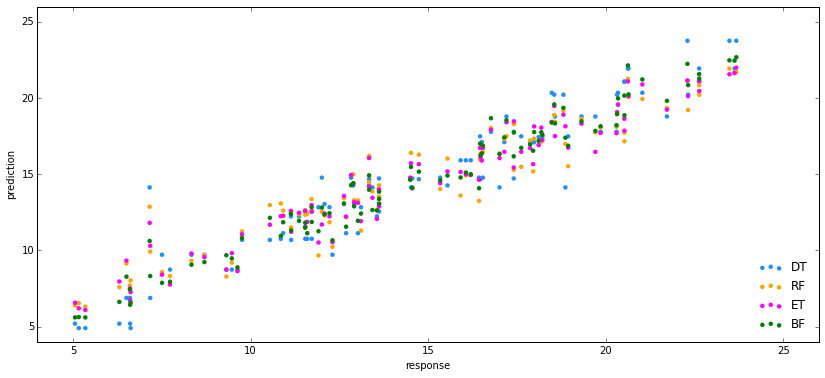

In [7]:
## a single analysis

n = 100
p = 10
X = rn.uniform(0,1,n*p).reshape(n,p)
y = fried(X)
f = fried(X,noisy=False)

#DT
fried_dt = tree.DecisionTreeRegressor(min_samples_leaf=3)
fried_dt.fit(X,y)
fried_dtp = fried_dt.predict(X)

#RF3
fried_rf = ensemble.RandomForestRegressor(100,min_samples_leaf=3)
fried_rf.fit(X,y)
fried_rfp = fried_rf.predict(X)

#ET
fried_et = ensemble.ExtraTreesRegressor(100,min_samples_leaf=3)
fried_et.fit(X,y)
fried_etp = fried_et.predict(X)

#BF
fried_bf = ensemble.RandomForestRegressor(100,min_samples_leaf=3,bootstrap=2)
fried_bf.fit(X,y)
fried_bfp = fried_bf.predict(X)

plt.scatter(f, fried_dtp, c="dodgerblue", label="DT",s=20,edgecolors='none')
plt.scatter(f, fried_rfp, c="orange", label="RF",s=20,edgecolors='none')
plt.scatter(f, fried_etp, c="fuchsia", label="ET",s=20,edgecolors='none')
plt.scatter(f, fried_bfp, c="green", label="BF",s=20,edgecolors='none')
plt.xlabel("response")
plt.ylabel("prediction")
plt.legend(frameon=False,loc=4)
plt.xlim(4,26)
plt.ylim(4,26)



In [8]:
def rmse(f,fhat):
    return np.sqrt(np.mean( (f-fhat)**2 ))


In [9]:

ne = 100
n = 100
p = 10
B = 100
msl = 3
fried_RMSE = {key: [] for key in ['DT','RF','ET','BF']}
for b in range(B):
    ### data
    Xtrain = rn.uniform(0,1,n*p).reshape(n,p)
    Xtest = rn.uniform(0,1,1000*p).reshape(1000,p)
    y = fried(Xtrain)
    f = fried(Xtest,noisy=False)
    
    #DT
    fried_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    fried_dt.fit(Xtrain,y)
    fried_dtp = fried_dt.predict(Xtest)
    fried_RMSE['DT'] += [rmse(f,fried_dtp)]
    
    #RF
    fried_rf = ensemble.RandomForestRegressor(n_estimators=ne,min_samples_leaf=msl)
    fried_rf.fit(Xtrain,y)
    fried_rfp = fried_rf.predict(Xtest)
    fried_RMSE['RF'] += [rmse(f,fried_rfp)]

    #ET
    fried_et = ensemble.ExtraTreesRegressor(n_estimators=ne,min_samples_leaf=msl)
    fried_et.fit(Xtrain,y)
    fried_etp = fried_et.predict(Xtest)
    fried_RMSE['ET'] += [rmse(f,fried_etp)]

    #BF
    fried_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2,min_samples_leaf=msl)
    fried_bf.fit(Xtrain,y)
    fried_bfp = fried_bf.predict(Xtest)
    fried_RMSE['BF'] += [rmse(f,fried_bfp)]

    print(b,end=" ")

fried_RMSE = pd.DataFrame(fried_RMSE)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

bart     1.811829
ET       2.618223
BF       2.669196
RF       2.755752
DT       3.711650
bcart    3.910470
dtype: float64

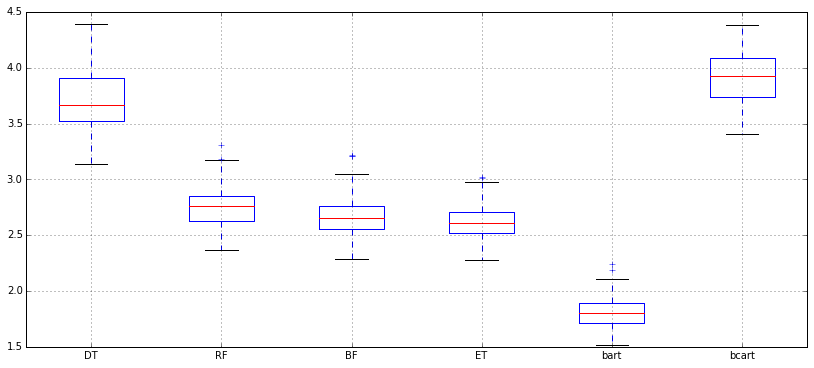

In [10]:
## cobine with output from code/bart.R, since this is not implemented in python
rdata = pd.read_table("graphs/bartfried.txt", sep=" ")
fried_RMSE = pd.concat([fried_RMSE,rdata])
fried_RMSE.boxplot(return_type='axes', column=['DT','RF','BF','ET','bart','bcart'])
fried_RMSE.mean().sort(inplace=False)


As predicted, the only model that assumes the (true) homoskedastic error structure, BART, well outperforms all others.  The two forests, BF and RF, are both a large improvement over a single decision tree.  The fully Bayesian BF is only about 1% better than the approximately Bayesian RF, as Bayesian and classical bootstrapping weights differ little in practice.  Both are outperformed slightly by the extremely random trees (ET), which might be expected due to the small sample size (for which the observed support approximation to population support, assumed in our forest interpretation, is poor).   The only suprise for us is the very poor performance of BCART (even worse than a single decision tree); we hypothesis that this is due to the notoriously poor mixing of the BCART MCMC, such that this fit is neither finding a posterior mean (as it is intended to) or optimizing to a local posterior mode (as DT does).

### California housing data

For the next example, we consider prediction of median home price by census block in california, based upon eight features of each region (location, income, housing stock).  The data are taken from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.   This problem has a response distribution that is difficult to summarize parametrically.  Standard analysis takes the log price as the response of interest, which at least tames some of the error heteroskedasticity.  Instead, we will attempt to model the conditional expection of raw dollar home values.  This mimics the setting common in the analysis of online transaction data (e.g. clicks or dollars spent), where the variable average effects and predictive performance on raw $ or click scale are of primary interest.

['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']


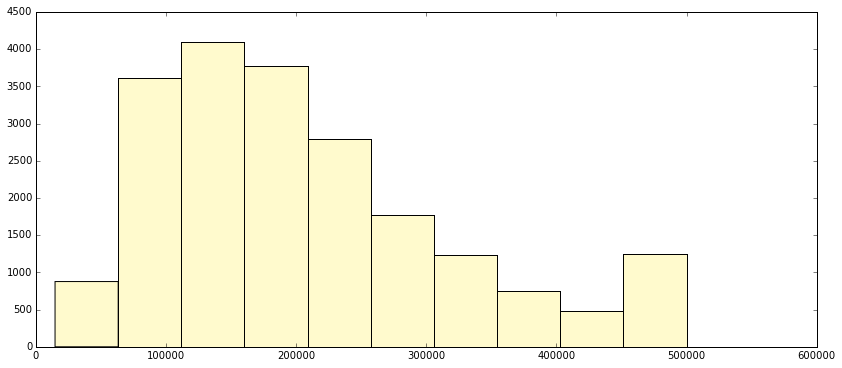

In [11]:
#### NB: this is the same data as:
# from sklearn.datasets import fetch_california_housing
# cah = fetch_california_housing(data_home="data")
# Xh = cah['data']
# yh = cah["target"]*1e5

cah = pd.read_csv('data/CAhousing.csv')
print(list(cah))
cah["medianIncome"] = cah["medianIncome"]*1e4
Xh = cah.drop("medianHouseValue",axis=1)
yh = cah["medianHouseValue"] 
cahist = plt.hist(cah["medianHouseValue"],color="lemonchiffon")

It appears from the histogram (and investigating the raw values) that the data has been capped at 500k.  In any case, the unconditional response has a long right tail, but is much more regular than what we commonly see in digital commerce applications (e.g., see Taddy et al, 2014, for transaction data with massive spikes at zero and at psychological price thresholds, as well as a tail that includes values 50k times larger than the mean).

In [12]:
from sklearn.cross_validation import KFold
kf = KFold(len(yh), n_folds=10,shuffle=True,random_state=5807)
## folds output for bart in R
import os
os.makedirs("data/cafolds", exist_ok=True)
k=0
for train, test in kf:
    np.savetxt("data/cafolds/%d.txt"%k,test,fmt='%d')
    k+=1


In [13]:
## run our loop
ne = 100
msl = 2
cah_RMSE = {key: [] for key in ['DT','RF','ET','BF']}
k=0
for train, test in kf:
    
    ### data
    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    ytrain = yh[train]
    ytest = yh[test]
    
    #DT
    cah_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    cah_dt.fit(Xtrain,ytrain)
    cah_dtp = cah_dt.predict(Xtest)
    cah_RMSE['DT'] += [rmse(ytest,cah_dtp)]
    
    #RF
    cah_rf = ensemble.RandomForestRegressor(n_estimators=ne,min_samples_leaf=msl,n_jobs=4)
    cah_rf.fit(Xtrain,ytrain)
    cah_rfp = cah_rf.predict(Xtest)
    cah_RMSE['RF'] += [rmse(ytest,cah_rfp)]

    #ET
    cah_et = ensemble.ExtraTreesRegressor(n_estimators=ne,min_samples_leaf=msl,n_jobs=4)
    cah_et.fit(Xtrain,ytrain)
    cah_etp = cah_et.predict(Xtest)
    cah_RMSE['ET'] += [rmse(ytest,cah_etp)]

    #BF
    cah_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2, n_jobs=4,
                                           min_weight_fraction_leaf=1e-4 )
    cah_bf.fit(Xtrain,ytrain)
    cah_bfp = cah_bf.predict(Xtest)
    cah_RMSE['BF'] += [rmse(ytest,cah_bfp)]
    
    print(k, end=" ")
    k+=1

cah_RMSE = pd.DataFrame(cah_RMSE)
print("done")

0 1 2 3 4 5 6 7 8 9 done


Note that bart fit takes around 75 sec in R, vs 10 sec for BF run in serial.

bart-BF: 0.131525620439
ET-BF: 0.0866511602873
RF-BF: 0.00380905017118


BF       48390.055024
RF       48574.375171
ET       52583.109438
bart     54754.587034
DT       65487.522295
bcart    82695.262723
dtype: float64

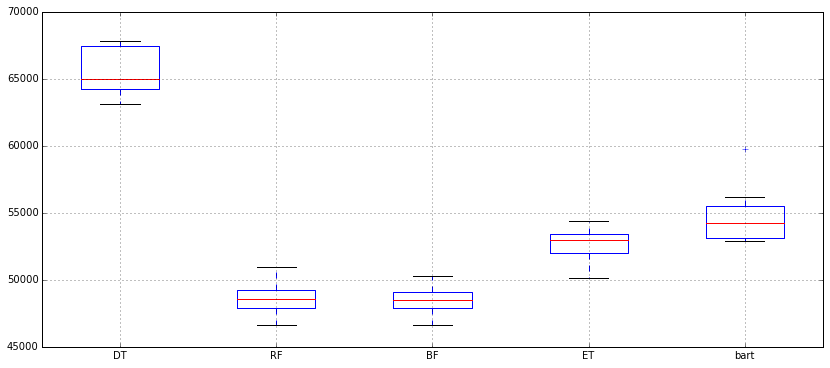

In [14]:
rdata = pd.read_table("graphs/bartca.txt", sep=" ")
cah_RMSE = pd.concat([cah_RMSE,rdata])
cah_RMSE.boxplot(return_type='axes', column=['DT','RF','BF','ET','bart'])
cah_MRMSE = cah_RMSE.mean()
print("bart-BF: " + str((cah_MRMSE["bart"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
print("ET-BF: " + str((cah_MRMSE["ET"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
print("RF-BF: " + str((cah_MRMSE["RF"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
cah_MRMSE.sort(inplace=False)


The results are now reversed (except for DT and BCART, which still underperform all others).  The methods which place no assumptions on the data generating process, RF and BF, do much better than BART and it's restrictive error model.  The implicit regularization of extratrees is no longer of any benefit, as the larger sample size means that our finite support approximation is solid.  As always, BF offers a real but small gain over RF.

## Empirical Bayesian Forests

The previous sections re-interpret forests (random or Bayesian -- they are roughly equivalent) as samples from the distribution-free posterior over greedy CART fits.   This interpretation is now applied to guide strategies for forest fit on massive data, by treating that problem as one of _approximate_ sampling from the posterior.  

_Empirical Bayes_ (EB) is an established framework with a successful track record in fast approximate Bayesian inference; see, e.g., <cite data-cite="efron_large-scale_2010">Efron (2010)</cite> for an overview. In parametric models, EB can be interpreted as fixing at their marginal posterior maximum (MAP) the parameters at higher levels of a _hierarchical model_.  For example, in the simple setting of many group means (the average student test score for each of many schools) shrunk to an overall global center (the outcome for an imaginary 'average school'), an EB procedure would first find the overall average test score across all schools and then shrink posterior estimated score means towards this value within each individual school.  <cite data-cite="kass_approximate_1989">Kass + Steffey (1989)</cite> investigate such procedures and show that, under fairly general conditions, the conditional posterior (conditioning on a marginal MAP overall average) for each group mean (school score average) quickly approaches the fully Bayesian unconditional posterior as the sample size grows.

CART trees are not a parametric model, but they are hierarchical and admit an interpretation similar to those studied in 
<cite data-cite="kass_approximate_1989">Kass + Steffey (1989)</cite>.  The data which reaches any given interior node is a function of the partitioning implied by nodes shallower in the tree.  Moreover, due to the _greedy_ algorithm through which CART grows, a given shallow tree is unaffected by changes to the tree structure below.  Finally (this point is investigated in detail in the next section),  the partitioning implied by shallower sub-trees is much more stable (has lower posterior variability) than the fully grown trees.  

An Empirical Baysian Forest (EBF) takes advantage of this hierarchical struture by fixing the highest levels in the hierarchy -- the earliest CART splits -- at a single estimate of high posterior probability.  We refer to this fixed sub tree as the _trunk_, and will generally take it as a large-leaf (i.e., short) CART fit to the entire dataset.  This is fit to unweighted data, which corresponds to the mean of our nonparametric Bayesian posterior over DGPs.  Based upon this trunk, data is partitioned into leaves of manageable size, and a forest is fit to each.  That is, EBF replaces the  BF posterior sample of trees with a conditional posterior sample that takes the pre-fit trunk as fixed at its marginal MAP.   Since this trunk has relatively low variance, the EBF  should provide predictions similar to that of the full BF.

EBF is contrasted to a common existing algorithm, which for Big Data simply splits the data into sub-samples and fits a forest to each (cite?).  This strategy can be justified from standard sampling theory as yeilding a tree average that is unbiased for the population tree average, but it discards information available in the full Big Data sample.  Given the high uncertainty and low effective sample sizes associated with deep tree structure (otherwise, we wouldn't need to bother with Big Data in the first place), such sub-sampling is ignoring potentially useful information.  Indeed, the next section argues that so long as the initial tree Trunk is not overfit, then EBF should outperform forest fits averaged across data subsets.  Either approach can be used in conjuntion with further techniques for distribution of the tree fit, e.g. via the PLANET MapReduce scheme of <cite data-cite="panda_planet:_2009">Panda et al (2009)</cite>.

### Uncertainty about trees


Theory on decision trees is sparse.  The original CART book of <cite data-cite="breiman_classification_1984">Breiman et al (1984)</cite> provides results on the consistency of tree partitioners;  they show that any partitioner that which is able to eventually learn enough to partition into very small-diameter leaves relative to the DGP probability function will be able to reproduce the conditional response distribution of that DGP.  However, this result says little about the structure of the underlying trees, nor does it say little about the ability of a tree to predict when there is not enough data to reproduce a finely partition the DGP.  Another set of theory focuses on the frequentist properties of individual split decisions.  In the original CHAID work of <cite data-cite="kass_exploratory_1980">Kass (1980)</cite>, split decisions (on soley categorical variables) are based upon $\chi^2$ tests of the contingency table at each leaf node.  <cite data-cite="loh_regression_2002">Loh (2002)</cite> and <cite data-cite="hothorn_unbiased_2006">Hothorn et al (2006)</cite> are example generalizations, both of which combat the various multiple testing and other biases inherrent in tree-building through a sequence of hypothesis tests.  However, such contributions provide little intuition about the variability of an entire decision tree or in the setting where we are not working from a no-split null hypothesis distribution.

Despite this lack of theory, it is widely recognized that there is a large amount of uncertainty (sampling, or posterior) about the structure of decision trees.  For example, <cite data-cite="geurts_investigation_2000">Geurts and Wehenkel</cite> present a large amount of simulation-based empirical evidence of tree uncertainty, and they find that the locations and order of split points in trees is sometimes no-better than random (indeed, this motivates work by the same authors on extremely random trees).  The intuition behind such randomness is clear: the probability of a tree having any given branch structure is the product of conditional probabilities for each successive split.  After a enough steps any specific tree approaches probability of zero.  This uncertainty argues for the inherrently 'Big' data requirements of flexible tree regression: there is enough model complexity and uncertainty that we need to bring as much data as possible to bear on learning.  This was observed by, e.g., the authors of <cite data-cite="panda_planet:_2009">Panda et al (2009)</cite> when they compare RFs fit to the full dataset to those averaged across tree fits on without-replacement sub-samples of the data (which is a common technique for fitting RFs in distribution).

However, it is possible that elements of the tree structure are relatively stable.  For example, in the context of boosting, <cite data-cite="appel_quickly_2013">Appel et al (2013)</cite> argue that the _conditionally_ optimal split locations for internal nodes (they call stumps) are learnable from subsets of the full data alocated to each node.  They use this to propose a faster boosting algorithm.  In this paper we make a related claim: the top of a tree (its trunk) has structure that is stable enough that it can be estimated in advance and fixed at a posterior mode.  Our argument for the potential stability of tree trunks begins with a result on the mean and variance of the difference, at each internal node, betwen MSE associated with the modal CART partioning and the MSE that results after a split at any other location.  The uncertainty associated with these statistics, the maximum of which determines our tree, is shown to shrink with $e^{-n}$ under our npB model.  This is reasurring.  Moreover, we can lower bound the probability of selecting the modal CART split among $p$ possible as 
$1 - \frac{p}{\sqrt{n}} e^{-n}$, which will be quickly close to one even if $p$ grows with $n$.

### Probability of the sample CART tree

We focus on regression trees for this example, wherein node impurity is measured as the sum of squared errors.  Consider the simplified setup where each $x_j \in \{0,1\}$ is a binary random variable (possibly created as a discretization of a continuous input or through dummy expansion of a categorical input).  Say that $\texttt{f}_j=\{i:x_{ij}=0\}$ and $\texttt{t}_j=\{i:x_{ij}=1\}$ are the corresponding implied partitions. We will derive the distribution for the  weighted SSE resulting from a split on any such variable,

$$
\sigma^2_j(\boldsymbol{\theta}) = \frac{1}{n}\sum_i \theta_i \left[y_i - \mu_j(x_{ij})\right]^2
$$

where $\mu_j(0) = \sum_{i \in \texttt{f}_j}y_i \,\theta_i/\left|\boldsymbol{\theta}_{\texttt{f}_j}\right|$ and 
$\mu_j(1) = \sum_{i \in \texttt{t}_j}y_i \,\theta_i/\left|\boldsymbol{\theta}_{\texttt{t}_j}\right|$.

We can simulate the posterior for $\sigma_j$ implied by the gamma posterior on weights $\boldsymbol{\theta}$, but an exact analytic expression is not available.  Instead, we follow the approach used in <cite data-cite="lancaster_note_2003">Lancaster (2003)</cite>, <cite data-cite="poirier_bayesian_2011">Poirier (2011)</cite>, and <cite data-cite="taddy_heterogeneous_2014">Taddy et al (2014)</cite>: we derive a first-order Taylor approximation to the function $\sigma_j$ and describe the posterior for that related functional.  In particular, the $1\times n$ gradient of $\sigma_j$ with respect to $\boldsymbol{\theta}$ is
\begin{align}
\nabla \sigma^2_j & = \nabla  \frac{1}{n}\left[\sum_i \theta_iy_i^2 - \frac{1}{\left|\boldsymbol{\theta}_{\texttt{f}}\right|}\left(\mathbf{y}_{\texttt{f}}'\boldsymbol{\theta}_{\texttt{f}}\right)^2
- \frac{1}{\left|\boldsymbol{\theta}_{\texttt{t}}\right|}\left(\mathbf{y}_{\texttt{t}}'\boldsymbol{\theta}_{\texttt{t}}\right)^2\right]
\end{align}
which has elements
$
\nabla_i \sigma^2_{j}  = \left(y_i - \mu(x_{ij})\right)^2/n
$

The Taylor approximation is then
$$
\sigma^2_j \approx \tilde\sigma^2_j  = \sigma^2_j(\boldsymbol{1}) + \nabla \sigma^2\big |_{\boldsymbol{\theta}=\mathbf{1}} (\boldsymbol{\theta} - \boldsymbol{1}) =  \frac{1}{n}\sum_i \theta_i \left(y_i - \bar{y}_j(x_{ij})\right)^2
$$
with $\bar y_j(0) = \frac{1}{n_{\texttt{f}_j}}\sum_{i \in \texttt{f}_j}y_i$ and $\bar y_j(t) = \frac{1}{n_{\texttt{t}_j}}\sum_{i \in \texttt{t}_j}y_i$ are the observed response averages in each partition.




Suppose that $\sigma_1(\boldsymbol{1}) < \sigma_j(\boldsymbol{1})~\forall j$, so that variable 1 is that selected to dictate partitioning by CART.  Then we can consider variability about this selection by looking at the difference betwen the approximate SSE for alternative partitions and this modal value,

$$
\Delta_j(\boldsymbol{\theta}) = \tilde\sigma_1^2 - \tilde\sigma_j^2 =  \frac{1}{n}\sum_i \theta_i
\left[\bar{y}_1^2(x_{i1})-\bar{y}^2_j(x_{ij}) - 2y_i\left(\bar{y}_1(x_{i1})-\bar{y}_j(x_{ij})\right)\right] \equiv \frac{1}{n}\sum_i \theta_i d_{ji}.
$$

Say $\mathbf{d}_j = [d_{j1}\ldots d_{jn}]'$ is the vector of squared error differences.  Then
the total difference has mean $\mathbb{E}\Delta_j  = \bar{d}_j$ and variance $\mathrm{var}\Delta_j =  \mathbf{d}_j'\mathbf{d}_j/n^2$. Since $\Delta_j$ is the mean of independent Gamma random variables with known means and variances, the central limit theorem applies so that delta converges in distribution to a Gaussian

$$
\sqrt{n}(\Delta_j(\boldsymbol{\theta}) -\bar{d}_j)\rightsquigarrow \mathrm{N}(0,~\mathbf{d}_j'\mathbf{d}_j/n ).
$$

Thus the full-sample CART split occurs if all $\Delta_j< 0 $, which occurs with probability (note $\bar d_j < 0$)

$$
\mathrm{p}\left(\Delta_j< 0 :~ j = 2\dots p \right) \geq 1 - \sum_{j=2}^p \mathrm{p}( \Delta_j > 0 )\rightsquigarrow 1 
 - \sum_{j=2}^p \Phi\left( -\frac{\sqrt{n}\left|\bar{d}_j\right|}{\sqrt{\mathbf{d}_j'\mathbf{d}_j/n}}\right) 
 \geq 1 -  \frac{1}{\sqrt{2\pi}} \sum_{j=2}^p \frac{\exp(-n z^2_j/2)}{z_j\sqrt{n}} 
$$

where $z_j = \left|\bar{d}_j\right|\left(\mathbf{d}_j'\mathbf{d}_j/n\right)^{-\frac{1}{2}}$ is sample mean increase in impurity over the sample standard deviation of impurity.  This ratio is bounded in probability, so that that the exponential bound goes to zero very quickly with $n$.  In particular, ignoring variation in $z_j$ across variables we get

$$
\mathrm{p}\left(\text{split matches sample CART}\right) \gtrsim 1 - \frac{p}{\sqrt{n}} e^{-n}.
$$

Thus, even in a more difficult setting where $p \approx n\times d$, with $d$ some underlying continuous variable dimension and $p$ the input dimension discretization on these variables,  the probability of the observed split goes to one at order $\mathcal{O}(n^{-1})$ if $d < e^{n}/n^{3/2}$.

Given this, why is there any uncertainty at all about trees?  The answer is recursion: each split is conditionally stable given the sample at the current node, but the probability of any specific sequence of splits is roughly (we don't actually have independence) the product of individual node split probabilities.  This can get small as we move deeper down the tree.  Moreover, given one split different from the sample CART tree, the rest of the tree will grow aribitrarily far from this modal structure.   In addition, the sample size going into our probability bounds is shrinking exponentially with each partition, whereas the dimension of elligible split variables is reduced only by one at each level.

### tree stability in california

We'll illustrate trunk stability and the idea of EBFs on the California housing data from above.  To begin, consider a _trunk_ with no less than 3500 census blocks (out of 20640 total) in each leaf partition.  Greedy CART leads to a five node tree.

In [15]:
ca_trunk = tree.DecisionTreeRegressor(min_samples_leaf=3500)
ca_trunk.fit(Xh,yh)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=3500, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

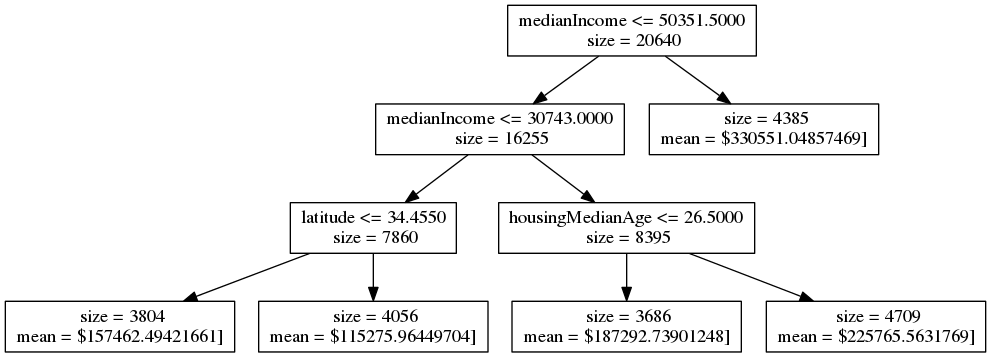

In [17]:
## plot it and show inline
tree.export_graphviz(ca_trunk,feature_names=list(Xh),out_file="graphs/catrunk.dot")
## a bunch of unescessary formatting (default is fine, but this is nicer)
!sed -i  's/mse = [0-9]*\.[0-9]*\\n/ /g' graphs/catrunk.dot
!sed -i  's/samples/size/g' graphs/catrunk.dot
!sed -i  's/\[ /\$/g' graphs/catrunk.dot
!sed -i  's/\.\]//g' graphs/catrunk.dot
!sed -i  's/value/mean/g' graphs/catrunk.dot

!dot -Tpng graphs/catrunk.dot -o graphs/catrunk.png
from IPython.display import Image
Image(filename='graphs/catrunk.png') 
# note that 34.5 degrees lat is just north of santa barbara

#### Shallow tree variance

The tree above represents the optimal (greedy) five partition CART.  As predicted by theory, it turns out to be very stable.  Running a random forest of trees which stop at this minimum leaf size, we get 

In [18]:
cah_forest = ensemble.RandomForestRegressor(n_estimators=100, bootstrap=2, n_jobs=4,
                                           min_samples_leaf=3500)
cah_forest.fit(Xh,yh)

RandomForestRegressor(bootstrap=2, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=3500,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
trees = cah_forest.estimators_
var = list(Xh)
splitvar = [ [var[v] for v in t.tree_.feature if v >= 0] for t in trees ]

ts = ['medianIncome', 'medianIncome', 'latitude', 'housingMedianAge']
print("freq of CART tree",ts,end=": ")
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'latitude', 'medianIncome']
print("freq of  tree",ts,end=": ")
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'medianIncome']
print("freq of  tree",ts,end=": ")
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'medianIncome',"housingMedianAge"]
print("freq of  tree",ts,end=": ")
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', "housingMedianAge"]
print("freq of  tree",ts,end=": ")
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'latitude']
print("freq of first three",ts,end=": ")
print(sum( s[:3] == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome']
print("freq of first two",ts,end=": ")
print(sum( s[:2] == ts for s in splitvar ))

print("freq of any split on latitude",end=": ")
print(sum( 'latitude' in s for s in splitvar ))

print("freq of any split on housingMedianAge",end=": ")
print(sum( 'housingMedianAge' in s for s in splitvar ))


freq of CART tree ['medianIncome', 'medianIncome', 'latitude', 'housingMedianAge']: 62
freq of  tree ['medianIncome', 'medianIncome', 'latitude', 'medianIncome']: 28
freq of  tree ['medianIncome', 'medianIncome', 'medianIncome']: 4
freq of  tree ['medianIncome', 'medianIncome', 'medianIncome', 'housingMedianAge']: 2
freq of  tree ['medianIncome', 'medianIncome', 'housingMedianAge']: 4
freq of first three ['medianIncome', 'medianIncome', 'latitude']: 90
freq of first two ['medianIncome', 'medianIncome']: 100
freq of any split on latitude: 90
freq of any split on housingMedianAge: 68


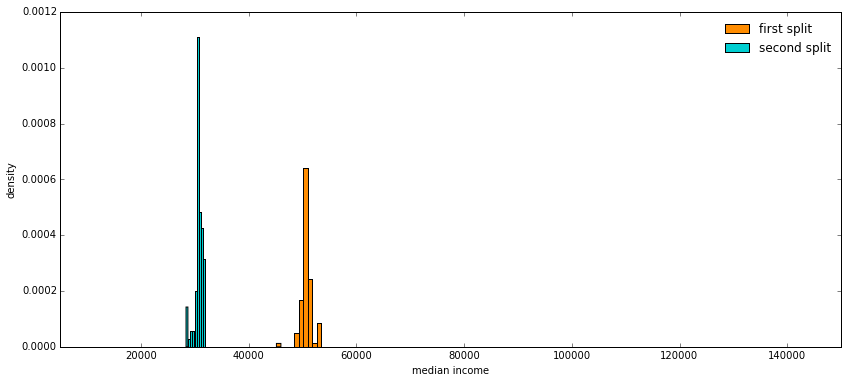

In [20]:

loc0 = [ t.tree_.threshold[0] for t in trees ]
loc1 = [ t.tree_.threshold[1] for t in trees ]

xlim = [min(Xh['medianIncome']),max(Xh['medianIncome'])]
plt.hist(loc0,color="darkorange",normed=True,label="first split")
plt.hist(loc1,color="darkturquoise",normed=True,label="second split")
plt.xlim(xlim)
plt.legend(frameon=False, loc='upper right')
plt.xlabel("median income")
plt.ylabel("density")


We can also repeatedly sample 90% of the data, and the CART fit with `min_sample_leaf=3500` is always similar: from visual inspection, each fold fit splits on the same variables, just on slightly different values.  Moreover, a Bayesian forest of trees limited to this node size does little better in OOS prediction (only 1%), offering additional evidence that the single CART fit is close to the posterior mean at this depth.

1.0

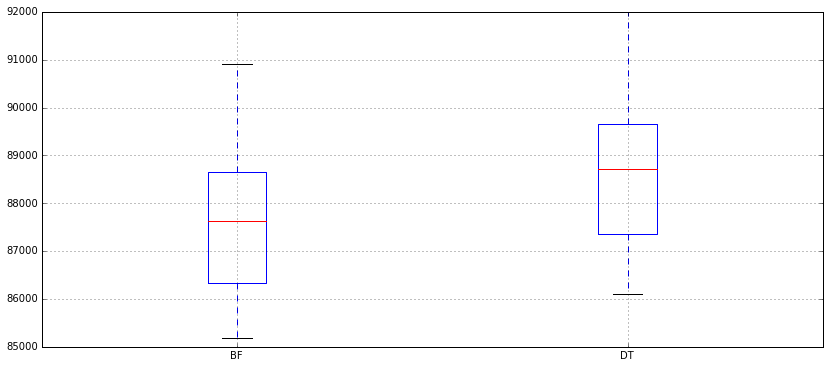

In [21]:
ne = 100
msl = 3500
shorte = {key: [] for key in ['DT','BF']}
def rmse(f,fhat):
    return np.sqrt(np.mean( (f-fhat)**2 ))

## run our loop
for train, test in kf:
    
    ### data
    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    y = yh[train]
    f = yh[test]
    
    #DT
    cashort_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    cashort_dt.fit(Xtrain,y)
    cashort_dtp = cashort_dt.predict(Xtest)
    shorte['DT'] += [rmse(f,cashort_dtp)]
    
    #BF
    cashort_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2,min_samples_leaf=msl)
    cashort_bf.fit(Xtrain,y)
    cashort_bfp = cashort_bf.predict(Xtest)
    shorte['BF'] += [rmse(f,cashort_bfp)]

shorte = pd.DataFrame(shorte)
shorte.boxplot(return_type='axes')
mshorte = shorte.mean()
round((mshorte['DT']-mshorte['BF'])/mshorte['BF']*100)

#### OOS experiment

Finally, we consider OOS prediction for the EBF, using a trunk fixed at the shallow trees from above, and averaging of Bayesian forests fit to sub-samples of comparable size.  The EBF does around 8% better than random sub-sampling, and only around 2% worse than the BF fit to the entire dataset.

In [22]:
def EBF(x,y,test,f,k=None,mslpre=3000,nblock=5,pretree=True,ntree=100):
    if pretree: 
        dt = tree.DecisionTreeRegressor(min_samples_leaf=mslpre)
        dt.fit(x,y)
        bvec = dt.tree_.apply(x.astype(tree._tree.DTYPE))
        print("%d leaves" % sum(dt.tree_.feature < 0), end=" ")
#         tree.export_graphviz(dt,
#                             feature_names=list(Xh),
#                             out_file="data/cafolds/tree%d.dot"%k)
    else:
        bvec = rn.random_integers(0,nblock-1,x.shape[0])
        print("%d obs in train" % x.shape[0], end=" ")
    bset = set(bvec)
    forest = {}
    for b in bset:
        print(b, end=" ")
        forest[b] = ensemble.RandomForestRegressor(
                        ntree,bootstrap=1,min_samples_leaf=3,n_jobs=4)
        isb = bvec==b
        forest[b].fit(x[isb,:],y[isb])
    
    if pretree:
        yhat = np.empty(test.shape[0])
        btest = dt.tree_.apply(test.astype(tree._tree.DTYPE))
        for b in bset:
            print(b, end=" ")
            isb = btest==b
            yhat[isb] = forest[b].predict(test[isb,:])
    else:
        yhat = np.zeros(test.shape[0])
        for b in bset:
            print(b, end=" ")
            yhat += forest[b].predict(test)/float(len(bset))
            
    err = rmse(f,yhat)
    print(err)
    return err


In [23]:
sube = {key: [] for key in ['pretree','randsamp']}
k = 0
for train, test in kf:
    print(k)

    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    y = yh[train]
    f = yh[test]
    
    sube['pretree'] += [EBF(Xtrain,y,Xtest,f,k=k)]
    sube['randsamp'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False)]
    
    k+=1


0
5 leaves 8 3 4 6 7 8 3 4 6 7 50944.0366206
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54142.9968149
1
5 leaves 8 3 4 6 7 8 3 4 6 7 49300.0932253
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54299.0262537
2
5 leaves 8 3 4 6 7 8 3 4 6 7 48533.7568667
18576 obs in train 0 1 2 3 4 0 1 2 3 4 52246.3699859
3
5 leaves 8 3 4 6 7 8 3 4 6 7 47345.9050715
18576 obs in train 0 1 2 3 4 0 1 2 3 4 51174.0732887
4
5 leaves 8 3 4 6 7 8 3 4 6 7 47708.1568956
18576 obs in train 0 1 2 3 4 0 1 2 3 4 51417.9202149
5
5 leaves 8 3 4 6 7 8 3 4 6 7 48923.0068763
18576 obs in train 0 1 2 3 4 0 1 2 3 4 52497.9745518
6
5 leaves 8 3 4 6 7 8 3 4 6 7 50341.8472296
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54119.2783726
7
5 leaves 8 3 4 6 7 8 3 4 6 7 50318.488166
18576 obs in train 0 1 2 3 4 0 1 2 3 4 55275.3634813
8
5 leaves 8 3 4 6 7 8 3 4 6 7 49932.8585373
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54568.5447255
9
5 leaves 8 3 4 6 7 8 3 4 6 7 50141.9933355
18576 obs in train 0 1 2 3 4 0 1 2 3 4 53480.2387014


2.0% worse than full sample BF
8.0% better than random sub sampling


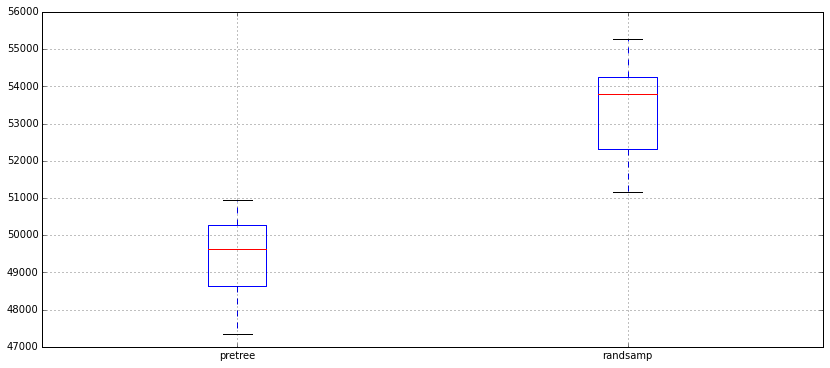

In [24]:
#!for K in `seq 0 9`; do dot -Tpdf data/cafolds/tree$K.dot -o data/cafolds/tree$K.pdf; done

sube = pd.DataFrame(sube)
sube.boxplot(return_type='axes')
msube = sube.mean()

print(round((msube['pretree']-cah_MRMSE['BF'])/cah_MRMSE['BF']*100), end="% ")
print("worse than full sample BF")
print(round((msube['randsamp']-msube['pretree'])/msube['pretree']*100), end="% ")
print("better than random sub sampling")


### Another example: wine quality

As another test of OOS performance, we consider the Vino Verde dataset of http://www3.dsi.uminho.pt/pcortez/wine/.   There are 4898 observations on 11 continuous attributes (physiochemical properties of the wine) plus wine color (red or white) as inputs, with an 'expert' quality ranking on the scale of 0-10 as response.  Here, we find that averaging forests fit to 5 random subsets of the data do 10% worse in OOS prediction than the EBF conditional on pre-tree partitioning into 5 leaves.  Here, the EBF does close to as well as a full forest: it is only 1% more expensive than the full BF fit.

['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


(array([  10.,    0.,   53.,    0.,  681.,    0.,  638.,    0.,  199.,   18.]),
 array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ]),
 <a list of 10 Patch objects>)

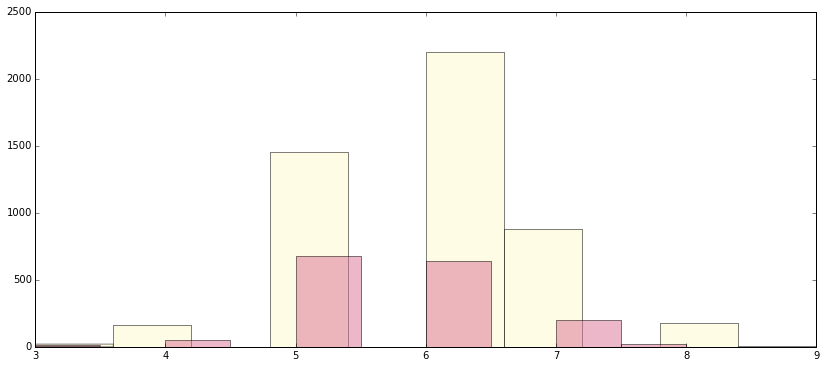

In [25]:
wine = pd.read_csv('data/wine.csv')
print(list(wine))
yw = wine["quality"] 
Xw = wine.drop("quality",axis=1)
Xw["color"] = (Xw["color"].values == "red").astype("int")
wine[wine.color == "white"]["quality"]
plt.hist(wine[wine.color == "white"]["quality"].values,alpha=0.5,color="lemonchiffon")
plt.hist(wine[wine.color == "red"]["quality"].values,alpha=0.5,color="palevioletred")


In [26]:
wine_RMSE = {key: [] for key in ['pretree','randsamp','fullbf']}
from sklearn.cross_validation import KFold
kw = KFold(len(yw), n_folds=10,shuffle=True,random_state=5807)

k = 0
for train, test in kw:
    print(k)

    Xtrain = Xw.iloc[train].values
    Xtest = Xw.iloc[test].values
    y = yw[train]
    f = yw[test]
    
    wine_RMSE['pretree'] += [EBF(Xtrain,y,Xtest,f,k=k,mslpre=1000)]
    wine_RMSE['randsamp'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False)]
    wine_RMSE['fullbf'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False,nblock=1)]

    k+=1


0
5 leaves 8 2 4 5 7 8 2 4 5 7 0.620392972682
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.673474573742
5847 obs in train 0 0 0.617286588523
1
4 leaves 2 4 5 6 2 4 5 6 0.65342357211
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.705536262655
5847 obs in train 0 0 0.654896994802
2
5 leaves 8 2 4 5 7 8 2 4 5 7 0.666675970556
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.724922808531
5847 obs in train 0 0 0.662875571152
3
5 leaves 8 2 4 5 7 8 2 4 5 7 0.575584866812
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.632799787875
5847 obs in train 0 0 0.564807376323
4
5 leaves 8 2 4 5 7 8 2 4 5 7 0.608842166257
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.670204696962
5847 obs in train 0 0 0.606176010593
5
5 leaves 8 2 4 5 7 8 2 4 5 7 0.60414093871
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.658878968991
5847 obs in train 0 0 0.606533453388
6
5 leaves 8 2 4 5 7 8 2 4 5 7 0.589246771508
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.671178294537
5847 obs in train 0 0 0.589898556987
7
5 leaves 8 2 4 5 7 8 2 4 5 7 0.610390984888
5848 obs

1.0% worse than full sample BF
10.0% better than random sub sampling


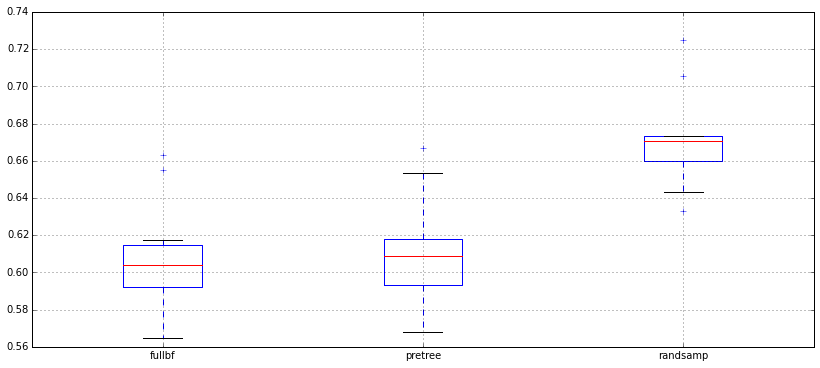

In [27]:
wine_RMSE = pd.DataFrame(wine_RMSE)
wine_RMSE.boxplot(return_type='axes')
wine_MRMSE = wine_RMSE.mean()

print(round((wine_MRMSE['pretree']-wine_MRMSE['fullbf'])/wine_MRMSE['fullbf']*100), end="% ")
print("worse than full sample BF")
print(round((wine_MRMSE['randsamp']-wine_MRMSE['pretree'])/wine_MRMSE['pretree']*100), end="% ")
print("better than random sub sampling")


## Discussion

Tree-based learning algorithms are massively useful and very popular.  However, the lack of parametric structure makes it difficult to find meaningful theoretical guidance for their performance in different settings.  This leads to an exclusive reliance upon cross validation experiments (and simulation studies) for evaluating candidate algorithms, 
which while informative is less helpful for a practitioner who needs to know which algorithm is best suited to particular data.  Bayesian modelling and interpretation of tree models is a help here, as the model assumptions and properties are transparent to anyone who is able to understand probabalistic models.  Our Bayesian Forests bring this intuition to one of the most heavily used tree-based algorithms, Random Forests, and thus allow it to be realated easily to other candidate Bayesian methods.  

The other contribution here, which likely has more practical implications, is the proposal of Empirical Bayesian forests.  Given our Baysian interpretation of Forests, the common idea of fixing high-level parameters with little uncertainty is applied in an algorithm that yields posterior mean predictions close to that of a forest fit to the full dataset while working efficiently on small sub-samples.  Even if one is not willing to assume in advance how deep a tree will be stable, in environments where forests are repeatedly re-fit (to incorporate incomming information) one can monitor the stability at higher levels and use this information to fix some tree elements in future runs.  This type of strategy is the key to efficient machine learning on Big Data: focus the use of massive samples on the pieces of models that are most difficult to estimate.

<br>